$$ \LaTeX \text{ command declarations here.}
\newcommand{\R}{\mathbb{R}}
\renewcommand{\vec}[1]{\mathbf{#1}}
\newcommand{\norm}[1]{\|#1\|_2}
$$

In [1]:
# plotting
%matplotlib inline
from matplotlib import pyplot as plt;
import matplotlib as mpl;
from mpl_toolkits.mplot3d import Axes3D

# scientific
import numpy as np;
import scipy as scp;
import scipy.stats;

# python
import random;

# rise config
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
              'theme': 'simple',
              'start_slideshow_at': 'selected',
              'transition':'fade',
              'scroll':False
})

# scikit-learn
from sklearn import svm
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.learning_curve import learning_curve
from sklearn.kernel_ridge import KernelRidge

# math
from __future__ import division

# EECS 545:  Machine Learning
## Lecture 08:  Kernel Methods, Part I
- Instructor:  **Jacob Abernethy**
- Date:  February 8, 2016


*Lecture Exposition Credit*:  Benjamin Bray, Saket Dewangan

## Outline

* Perceptron Algorithm
* Recap Classification Algorithms
* Kernel Methods
    - Kernel functions
    - Kernel trick
    - Constructing kernels

## Perceptron Algorithm
* The *Perceptron*, perhaps the oldest "learning algorithm", goes back to Rosenblatt in the 1960s
* The Perceptron is the most basic model of a training a linear predictor with sequential update steps:
-------------

**INIT:** set $\vec{w}_1 = \mathbf{0}$;

**FOR:** $t=1,2,\ldots$
  * Observe $\vec{x}_t$, predict $\hat{y}_t = \text{sign}(\vec{w}_t ^{\top} \phi(\vec{x}_t))$
  * Receive $y_t \in \{-1,1\}$, update:
$
\vec{w}_{t+1} = \begin{cases}
\vec{w}_t, & \text{if } y_t\vec{w}_t ^{\top} \phi(\vec{x}_t) > 0\\
\vec{w}_t + y_t \phi(\vec{x}_t), & \mbox{otherwise.}
\end{cases}
$

## Perceptron is just Stochastic Gradient Descent
* Perceptron update: 
$$
\vec{w}_{t+1} = \begin{cases}
\vec{w}_t, & \text{if } y_t\vec{w}_t ^{\top} \phi(\vec{x}_t) > 0\\
\vec{w}_t + y_t \phi(\vec{x}_t), & \mbox{otherwise.}
\end{cases}
$$
* This is just SGD on the following error func.:
$$
E(\vec{w}) := \sum_{t=1}^n \max(0, -y_t \vec{w}^\top \phi(\vec{x}_t))
$$
* Notice the "step size" is $\eta = 1$! This is atypical.
* Perceptron was (originally) viewed as building block of the *neural network* (NN). Indeed, NN often called the MultiLayerPerceptron (MLP).

## Perceptron has a magical property
* If problem is *linearly separable*, i.e. a hyperplane separates positives/negatives, then Perceptron *will find a separating* $\vec{w}^*$.
* **Theorem**: 
    * Assume that $\|\vec{x}_t\| \leq 1$ for all $t$
    * Assume $\exists \vec{w}$, with $\|\vec{w}\|_2 = 1$, such that for all $(\vec{x}_t,y_t)$ that $ y_t\vec{w} ^{\top} \phi(\vec{x}_t) > \gamma$ for some $\gamma > 0$.
    * Then the Perceptron algorithm will find some $\vec{w}^*$ which perfectly classifies all examples
    * The number of updates/mistakes in learning is bounded by $\frac{1}{\gamma^2}$
* This is a *margin bound*, notice that it depends on $\gamma$ not the dimension of $\phi(\vec{x})$

**Proof Sketch**: (See [learning theory lecture notes](http://web.eecs.umich.edu/~jabernet/eecs598course/fall2015/web/notes/lec16_110515.pdf) for full details.)

Let $\vec{w}_*$ be perfect classifier scaled by $\frac{1}{\gamma}$.
\begin{align}
\frac{1}{\gamma^2} = \norm{\vec{w}_*}^2 & \ge \norm{\vec{w}_* - \mathbf 0}^2 - \norm{\vec{w}_* - \vec{w}_{T+1}} \nonumber \\
& = \sum_{t=1}^T \norm{\vec{w}_* - \vec{w}_{t}}^2 - \norm{\vec{w}_* - \vec{w}_{t+1}}^2  \\
& = \sum_{t:y_t(\vec{w}_t^\top \vec{x}_t)<0} \norm{\vec{w}_* - \vec{w}_{t}}^2 - \norm{\vec{w}_* - (\vec{w}_t + y_t \vec{x}_t)}^2 \\
& = \sum_{t:y_t(\vec{w}_t^\top \vec{x}_t)<0} 2 \left( \underbrace{y_t (\vec{w}_*^{\top}\vec{x}_t)}_{\ge 1} \underbrace{- y_t (\vec{w}_t^{\top}\vec{x}_t)}_{\ge 0} \right) \underbrace{- y_t^2 \norm{\vec{x}_t}^2}_{\ge -1} \\
& \ge \sum_{t:y_t(\vec{w}_t^\top \vec{x}_t)<0} 1 \quad = \quad \text{#mistakes[Perceptron]}
\end{align}

## A Recap of Classification Methods
* **Logistic Regression**
    * Provides model for $P(y | x, w)$ using sigmoid
    * No explicit model for $P(x | w)$ or $P(x | y, w)$
* **Naive Bayes**
    * Provides a full model for $P(x,y|w)$
    * Assumes independence between features *conditioned on* target $y$
    * Typically requires discrete data (can generalize to continuous spaces)
    * ML estimates are pretty straightforward

## A Recap of Classification Methods
* **Gaussian Discriminant Analysis**
    * Gives full model $P(x|y,w)$ via *multivariate Gaussian*
    * Requires esimating $\mu, \Sigma$ for each class
    * When we include additional assumption that all class covariances matrices are identical, we get *Linear Discriminant Analysis*, and decision threshold becomes linear. (**Exercise:** why?)
* **Perceptron**
    * No probability model on $x,y,w$
    * Can prove algorithmic benefits (i.e. guaranteed convergence) under *margin assumption*

## References

This lecture draws upon the following resources:

- **[MLAPP]** Murphy, Kevin. [*Machine Learning:  A Probabilistic Perspective*](https://mitpress.mit.edu/books/machine-learning-0).  2012.
- **[PRML]** Bishop, Christopher.  [*Pattern Recognition and Machine Learning*](http://www.springer.com/us/book/9780387310732).  2006.
- **[CS229]** Ng, Andrew.  [CS 229:  Machine Learning](http://cs229.stanford.edu/).  Autumn 2015.
    - Lecture Notes 03:  [Support Vector Machines & Kernels](http://cs229.stanford.edu/notes/cs229-notes3.pdf)

# Feature Mapping:  Linear Regression

<br><div style="text-align: center">*(recall Lectures 04 & 05)*</div>

### Review:  Feature Mapping

Our models so far employ a nonlinear **feature mapping** $\phi : \mathcal{X} \mapsto \R^M$
- in general, features are nonlinear functions of the data
- each feature $\phi_j(x)$ extracts important properties from $x$

Allows us to use *linear* methods for *nonlinear* tasks.
- For example, **polynomial features** for linear regression...

### Linear Regression:  Polynomial Features

**Problem:** Linear model $y(x) = w^T x$ can only produce straight lines through the origin.
- Not very flexible / powerful
- Can't handle nonlinearities

**Solution:** Polynomial Regression
- Replace $x$ by $\phi(x) = \begin{bmatrix} 1 & x & x^2 & \cdots & x^p \end{bmatrix}^T$
- The feature mapping $\phi$ is nonlinear

### Linear Regression:  Polynomial Features

In [2]:
def poly_reg_example(fn):
    # generate random points
    x = np.random.random(20) * 5;
    y = fn(x);
    # format into matrix
    X = x[:, np.newaxis];
    
    # plot ground truth
    x_plot = np.linspace(0,5,100)[:, np.newaxis];
    plt.plot(x_plot, fn(x_plot), label="ground truth")
    plt.scatter(x, y, label="data-points")

    # polynomial regression for degree 1,3 and 5
    for degree in [1, 3, 5]:
        model = make_pipeline(PolynomialFeatures(degree), Ridge())
        model.fit(X, y)
        y_plot = model.predict(x_plot)
        plt.plot(x_plot, y_plot, label="degree %d" % degree)
    
    plt.legend(loc='lower left')
    plt.show()
    

### Linear Regression:  Polynomial Features

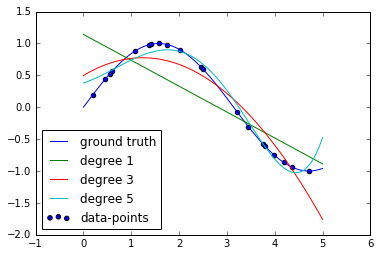

In [3]:
# ground truth:  function to be approximated
def fn(x): return np.sin(x);

# plot
poly_reg_example(fn);

### Linear Regression: Nonlinear Features

Linear Regression Model 
$$ y(x,w) = w^T \phi (x) = \sum_{j=0}^{M} w_j \cdot \phi_j(x) $$

Least-squares with L-2 regularization
$$ J(w) = \frac{1}{2} \sum_{n=1}^{N}(w^T \phi (x_n) - t_n)^2 + \frac{\lambda}{2}w^Tw $$

Closed-form Solution
$$ w = (\phi^T \phi + \lambda I)^{-1}\phi^T \cdot t $$

### This is neat, but...

How do I choose a feature mapping $\phi(x)$?
- Manually?  Learn features?

With $N$ examples and $M$ features,
- design matrix is $\Phi \in \R^{N \times M}$
- linear regression requires inverting $\Phi^T \Phi \in \R^{M \times M}$
- computational complexity of $O(M^3)$
        

# Feature Mapping:  Linear Classifiers

<br><div style="text-align: center">*(recall Lectures 06 & 07)*</div>

### Linear Classifiers:  Review

**Recall:**  Linear (binary) classifiers separate data with a **hyperplane** in feature space,

$$
h(x) = \begin{cases}
    1 & \text{if } w^T \phi(x) > 0 \\
    0 & \text{otherwise}
\end{cases}
$$

**Examples:** Differ only in how the weights $w$ are learned.
- Logistic regression
- Linear Discriminant Analysis
- Fisher's Linear Discriminant
- Perceptron Learning

### Feature Mapping:  Example

In [4]:
def get_circular_data(n):
    # sample outer circle
    theta0 = np.random.random(n) * 2 * np.pi;
    r0 = 2 + np.random.randn(n) / 3;
    # sample inner circle
    theta1 = np.random.random(n) * 2 * np.pi;
    r1 = 5 + np.random.randn(n) / 3;
    # join data
    x0 = r0 * [np.cos(theta0), np.sin(theta0)];
    x1 = r1 * [np.cos(theta1), np.sin(theta1)];
    return x0, x1;

def plot_circular_data(n):
    # get data
    x0, x1 = get_circular_data(n);

    # plot
    plt.figure(figsize=(10,6))
    plt.scatter(*x0, c="r")
    plt.scatter(*x1, c="b", marker="^")
    plt.axis("equal");

def plot_circular_3d(n):
    # get data
    x0, x1 = get_circular_data(n);
    
    # plot
    fig = plt.figure(figsize=(10,6));
    ax = fig.add_subplot(111, projection='3d');
    # plot 3d points
    ax.scatter(*x0, np.linalg.norm(x0, axis=0)**2, c="r")
    ax.scatter(*x1, np.linalg.norm(x1, axis=0)**2, c="b", marker="^");
    # set camera
    ax.view_init(elev=20, azim=45);

def plot_circular_squared(n):
    # get data
    x0, x1 = get_circular_data(n);

    # plot
    plt.figure(figsize=(10,6))
    plt.scatter(*(x0**2), c="r")
    plt.scatter(*(x1**2), c="b", marker="^")
    plt.axis("equal");

### Feature Mapping:  Example

**Problem:**  The following data is **not** linearly separable.
- Every linear classifier will fail.

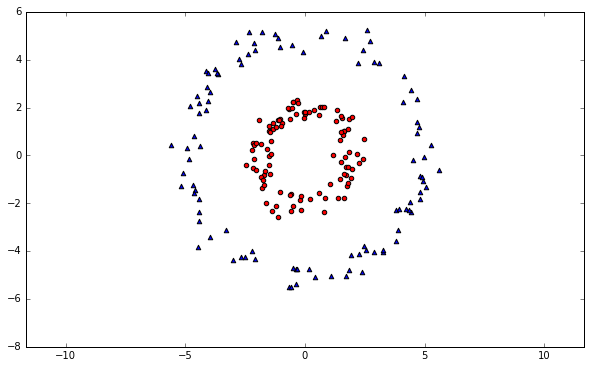

In [5]:
plot_circular_data(100);

### Feature Mapping:  Example

**Solution 1:**  Add squared-distance-to-origin $(x_1^2 + x_2^2)$ as third feature.

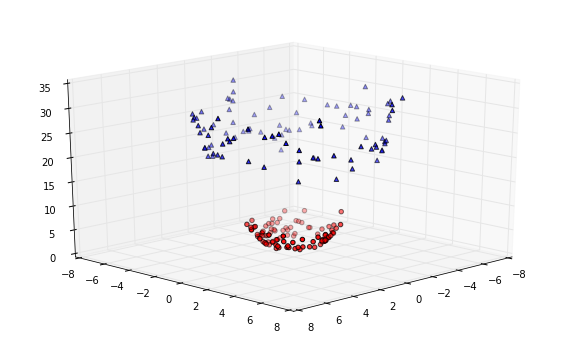

In [6]:
plot_circular_3d(100);

### Feature Mapping:  Example

**Solution 2:**  Replace $(x_1, x_2)$ with $(x_1^2, x_2^2)$

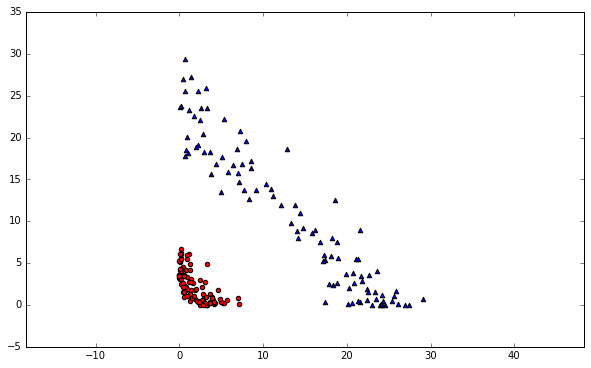

In [7]:
plot_circular_squared(100);

### Feature Mapping:  Linear Classifiers

Data has been mapped via $\phi$ to a new, higher-dimensional (possibly infinite!) space
- Certain *representations* are better for certain problems

Alternatively, the data still lives in original space, but the definition of **distance** or **inner product** has changed.
- Certain *inner products* are better for certain problems

### Feature Mapping:  Linear Classifiers

Unfortunately, higher-dimensional features come at a price!
- We can't possibly manage infinite-dimensional $\phi(x)$!
- Computational complexity blows up.

Kernel methods to the rescue!

# Kernel Functions

> Uses content from **[PRML]** and [Wikipedia, "Kernel Method"](https://en.wikipedia.org/wiki/Kernel_method)

### Kernel Methods:  Intro

Many algorithms depend on the data only through pairwise **inner products** between data points,
$$
\langle x_1, x_2 \rangle = x_2^T x_1
$$

Inner products can be replaced by **Kernel Functions**, capturing more general notions of *similarity*.
- No longer need coordinates!

### Kernel Functions:  Definition

A **kernel function** $\kappa(x,x’)$ is intended to measure the similarity between $x$ and $x’$.
- So far, we have used the standard inner product in the **transformed space**,
    $$ \kappa(x, x') = \phi(x)^T \phi(x')^T $$

- In general, $\kappa(x, x')$ is any symmetric positive-semidefinite function.

### Kernel Functions:  Implicit Feature Map

For every valid kernel function $\kappa(x, x')$,
- there is an implicit feature mapping $\phi(x)$
- corresponding to an inner product $\phi(x)^T \phi(x')$ in some high-dimensional feature space

This *incredible* result follows from **Mercer's Theorem**,
- Generalizes the fact that *every positive-definite matrix corresponds to an inner product*
- For more info, see Hsing & Eubank 2015, ["Theoretical Foundations of Functional Data Analysis"](http://www.wiley.com/WileyCDA/WileyTitle/productCd-0470016914.html)

### Kernel Functions:  Simple Example

**Kernel:** For $x = (x_1, x_2)$ and $z=(z_1, z_2)$, define
$$
\begin{align}
\kappa(x, z)
&= (x^Tz)^2 \\
&= (x_1z_1 + x_2z_2)^2 \\
&= x_1^2z_1^2 + 2x_1z_1x_2z_2 + x_2^2z_2^2 
\end{align}
$$

**Mapping:**  Equivalent to the standard inner product when either
$$
\begin{gather}
\phi(x) = (x_1^2, \sqrt{2} x_1 x_2, x_2^2) \\
\phi(x) = (x_1^2, x_1 x_2, x_1 x_2, x_2^2)
\end{gather}
$$

> Implicit mapping is **not** unique!

### Kernel Functions:  Polynomial Example

**Kernel:** Higher-order polynomial of degree $p$,
$$
\kappa(x,z)
= (x^T z)^p
= \left( \sum_{k=1}^M x_k z_k \right)^p
$$

**Mapping:** Implicit feature vector $\phi(x)$ contains all monomials of degree $p$

### Kernel Functions:  Polynomial Example

**Kernel:** Inhomogeneous polynomial up to degree $p$, for $c > 0$,
$$
\kappa(x,z)
= (x^T z + c)^p
= \left(c + \sum_{k=1}^M x_k z_k \right)^p
$$

**Mapping:** Implicit feature vector $\phi(x)$ contains all monomials of degree $\leq p$

### Example: Handwritten Digits

Take the pixel values and compute $\kappa(x,z) = (x^Tz + 1)^p $
- here, $x$ = $28 \times 28 = 784$ pixels  

<img src="images/hand_writ_example.png" width=200px, align="middle">

You can compute the inner product in the space of all monomials up to degree $p$
- (for $dim(x)=784$ and $p=4$ a $16G$ dimensional space!)

### The Kernel Trick

- By using different definitions for inner product, we can compute inner products in a high dimensional space, with only the computational complexity of a low dimensional space.
- Many algorithms can be expressed completely in terms of kernels $\kappa(x,x’)$, rather than other operations on $x$.
- In this case, you can replace one kernel with another, and get a new algorithm that works over a different domain.

### Dual Representation and Kernel Trick

* The dual representation, and its solutions, are entirely written in terms of kernels.

* The elements of the Gram matrix  $ K =\Phi \Phi^T $
$$ K_{ij} = \kappa(x_i, x_j) = \phi(x_i)^T \phi(x_j) $$

* These represent the pairwise similarities among all the observed feature vectors.
    - We may be able to compute the kernels more efficiently than the feature vectors.

### Kernel Substitution

* To use the kernel trick, we must formulate (training and test) algorithms purely in terms of inner products between data points

* We can *not* access the coordinates of points in the high-dimensional feature space

* This seems a huge limitation, but it turns out that quite a lot can be done

### Example: Distance

Distance between samples can be expressed in inner products:
$$
\begin{align}
||\phi(x) - \phi(z) ||^2
&= \langle\phi(x)- \phi(z), \phi(x)- \phi(z) \rangle\\
&= \langle \phi(x), \phi(x)\rangle - 2\langle\phi(x), \phi(z)\rangle + \langle\phi(z), \phi(z) \rangle \\
&= \kappa(x,x) - 2\kappa(x,z) + \kappa(z,z)
\end{align}
$$

Nothing stops you from doing **k-nearest neighbor searches** in high dimensional spaces
> (Phew!!)

### Example:  Mean

**Question:**  Can you determine the mean of data in the mapped feature space through kernel operations only?

**Answer:** No, you cannot compute any point explicitly.

### Example:  Distance to the Mean

* Mean of data points given by: $\phi(s) = \frac{1}{N}\sum_{i=1}^{N}\phi(x_i)$

* Distance to the mean:
$$
\begin{align}
||\phi(x) - \phi_s ||^2
&= \langle\phi(x)- \phi_s, \phi(x)- \phi_s \rangle\\
&= \langle \phi(x), \phi(x)\rangle - 2\langle\phi(x), \phi_s\rangle + \langle\phi_s, \phi_s \rangle \\
&= \kappa(x,x) - \frac{2}{N}\sum_{i=1}^{N}\kappa(x,x_i) + \frac{1}{N^2}\sum_{j=1}^{N}\sum_{i=1}^{N}\kappa(x_i,x_j)
\end{align}
$$


### Constructing Kernels

**Method 1:** Explicitly define a feature space mapping $\phi(x)$ and use **inner product kernel**
$$
\kappa(x,x')
= \phi(x)^T \phi(x')
= \sum_{i=1}^{M}\phi_i(x) \phi_i(x')
$$

### Constructing Kernels

**Method 2:** Explicitly define a kernel $\kappa(x,x')$ and identify the implicit feature map, e.g.
$$
\kappa(x,z) = (x^Tz)^2
\quad \implies \quad
\phi(x) = (x_1^2, \sqrt{2} x_1 x_2, x_2^2)
$$

> Kernels help us avoid the complexity of explicit feature mappings.

### Constructing Kernels

**Method 3:** Define a similarity function $\kappa(x, x')$ and use **Mercer's Condition** to verify that an implicit feature map *exists* without finding it.

- Define the Gram matrix $K$ to have elements $K_{nm} = \kappa(x_n,x_m)$
- $K$ must **positive semidefinite** for all possible choices of the data set {$x_n$}
$$
a^TKa
\equiv \sum_{i}\sum_{j} a_i K_{ij} a_j \geq 0 \quad \forall\, a \in \R^n
$$ 

### Constructing Kernels:  Building Blocks

There are a number of axioms that help us construct new, more complex kernels, from simpler known kernels. 
- Check out **[PRML]** Chapter 6
- Prove these as an exercise!

For example, the following are kernels:
$$
\begin{align}
\kappa(x, x') &= f(x) \kappa_1(x,x') f(x') \\
\kappa(x, x') &= \exp( \kappa_1(x, x') ) \\
\kappa(x, x') &= \exp\left( - \frac{|| x - x' ||^2 }{2\sigma^2} \right)
\end{align}
$$

### Popular Kernel Functions

Simple Polynomial Kernel (terms of degree $2$)
$$\kappa(x,z) = (x^Tz)^2 $$

Generalized Polynomial Kernel (degree $M$)
$$\kappa(x,z) = (x^Tz + c)^M, c > 0 $$

Gaussian Kernels
$$ \kappa(x,z) = exp \left\{-\frac{||x-z||^2}{2\sigma^2} \right\} $$

### Gaussian Kernel

> **Not related to Gaussian pdf!**

* Translation invariant (depends only on distance between points)

* Corresponds to an infinitely dimensional space!
    - **Important:** Do PRML Exercise 6.11